In [1]:
import cv2
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline  

from heatmap_estimator import HeatmapEstimator
from projection_dataset import ProjectionDataset
%load_ext autoreload
%autoreload 2

In [2]:
dataset_dir = "../data/projections"
plane = "XY" # Other planes: YZ and ZX
model_path = "../models/" + plane + ".pth"

In [3]:
train_subjects = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8"]
train_gestures = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "I", "IP", "L", "MP", "RP", "T", "TIP", "Y"]
train_dataset = ProjectionDataset(dataset_dir, train_subjects, train_gestures, plane)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

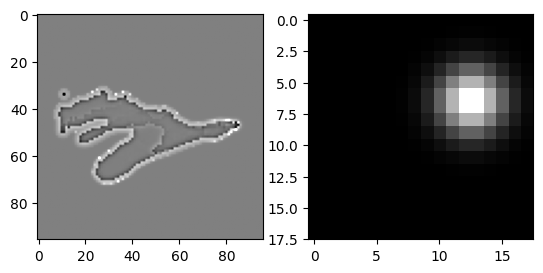

In [4]:
# Visualize sample
image, heatmap_gt = next(iter(train_dataloader))

fig, (plt1, plt2) = plt.subplots(1, 2)
plt1.imshow(torch.squeeze(image[0], 0).numpy(), cmap='gray', vmin=-1, vmax=1)
plt2.imshow(torch.squeeze(heatmap_gt[0][0], 0).numpy(), cmap='gray', vmin=0, vmax=1)

In [5]:
val_subjects = ["P0"]
val_gestures = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "I", "IP", "L", "MP", "RP", "T", "TIP", "Y"]
val_dataset = ProjectionDataset(dataset_dir, val_subjects, val_gestures, plane)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [6]:
# Load the model
device = 'cuda'
model = HeatmapEstimator().to(device)

In [7]:
# Configure the optimizer and criterion
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=0.0005)
criterion = torch.nn.MSELoss()

Computing epoch 0
Minibatch 0 Loss = 0.03425639
Minibatch 50 Loss = 0.03321435
Minibatch 100 Loss = 0.03171936
Minibatch 150 Loss = 0.02904536
Minibatch 200 Loss = 0.02600127
Minibatch 250 Loss = 0.02537735
Plotting sample validation figures


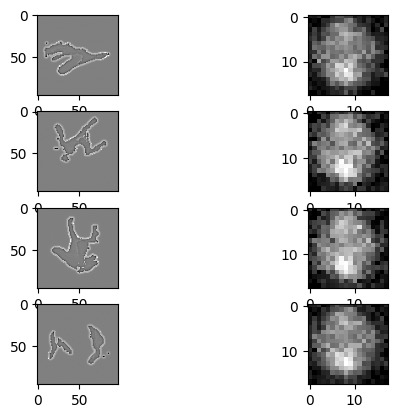

Epoch 0: Training Loss = 0.02965724, Validation Loss = 0.02538386
Computing epoch 1
Minibatch 0 Loss = 0.02482685
Minibatch 50 Loss = 0.02475038
Minibatch 100 Loss = 0.02478698
Minibatch 150 Loss = 0.02491748
Minibatch 200 Loss = 0.02466246
Minibatch 250 Loss = 0.02447318
Epoch 1: Training Loss = 0.02481540, Validation Loss = 0.02513053
Computing epoch 2
Minibatch 0 Loss = 0.02474202
Minibatch 50 Loss = 0.02451349
Minibatch 100 Loss = 0.02481688
Minibatch 150 Loss = 0.02476197
Minibatch 200 Loss = 0.02468802
Minibatch 250 Loss = 0.02460759
Epoch 2: Training Loss = 0.02468750, Validation Loss = 0.02504250
Computing epoch 3
Minibatch 0 Loss = 0.02440886
Minibatch 50 Loss = 0.02477424
Minibatch 100 Loss = 0.02456350
Minibatch 150 Loss = 0.02470930
Minibatch 200 Loss = 0.02435108
Minibatch 250 Loss = 0.02498655
Epoch 3: Training Loss = 0.02461455, Validation Loss = 0.02498886
Computing epoch 4
Minibatch 0 Loss = 0.02467606
Minibatch 50 Loss = 0.02456553
Minibatch 100 Loss = 0.02447264
Mini

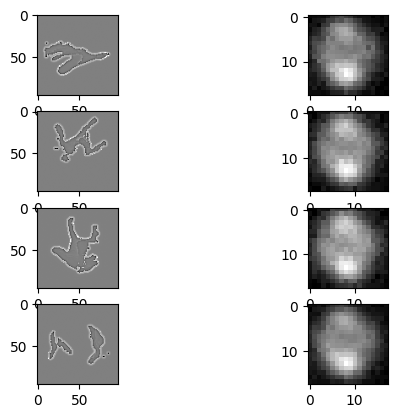

Epoch 5: Training Loss = 0.02450999, Validation Loss = 0.02489845
Computing epoch 6
Minibatch 0 Loss = 0.02423929
Minibatch 50 Loss = 0.02443420
Minibatch 100 Loss = 0.02455238
Minibatch 150 Loss = 0.02430881
Minibatch 200 Loss = 0.02433057


KeyboardInterrupt: 

In [8]:
# Main training loop
epochs = 50
train_loss_over_epochs = []
val_loss_over_epochs = []
for epoch in range(epochs):
    print("Computing epoch", epoch)
    minibatch = 0

    train_loss = 0
    for lcn, heatmaps in train_dataloader:    
        optimizer.zero_grad()
        
        lcn = lcn.type(torch.FloatTensor).to(device)
        lcn = torch.unsqueeze(lcn, dim=1)
        pred = model(lcn)
        
        heatmaps = heatmaps.type(torch.FloatTensor).to(device)
        loss = criterion(pred, heatmaps)
        
        loss.backward()
        optimizer.step()
        
        if (minibatch % 50 == 0):
            print("Minibatch {} Loss = {:.8f}".format(minibatch, loss.item()))
        minibatch += 1    
            
        train_loss += loss.cpu().item()
    train_loss /= len(train_dataloader)
    train_loss_over_epochs.append(train_loss)     
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for lcn, heatmaps in val_dataloader:
            lcn = lcn.type(torch.FloatTensor).to(device)
            lcn = torch.unsqueeze(lcn, dim=1)
            pred = model(lcn)

            heatmaps = heatmaps.type(torch.FloatTensor).to(device)
            
            if ((val_loss == 0) and (epoch % 5 == 0)):
                print("Plotting sample validation figures")
                fig, axes = plt.subplots(4, 2)
                for i in range(4):
                    axes[i, 0].imshow(torch.squeeze(image[i], 0).numpy(), cmap='gray', vmin=-1, vmax=1)
                    
                    im_max = np.max(pred[i][0].cpu().numpy())
                    axes[i, 1].imshow(torch.squeeze(pred[i][0], 0).cpu().numpy() / im_max, cmap='gray', vmin=0, vmax=1)
                plt.show()
            
            loss = criterion(pred, heatmaps)
            val_loss += loss.cpu().item()
    val_loss /= len(val_dataloader)
    val_loss_over_epochs.append(val_loss)
    
    if (epoch + 1 % 10 == 0):
        for g in optimizer.param_groups:
            g['lr'] /= 2
        
        
    
    print("Epoch {}: Training Loss = {:.8f}, Validation Loss = {:.8f}".format(epoch, train_loss, val_loss))

In [ ]:
# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.ylabel('Loss')
plt.plot(np.arange(epochs), train_loss_over_epochs, color='red', label='train')
plt.plot(np.arange(epochs), val_loss_over_epochs, color='blue', label='val')
plt.title('Loss per Epoch')
plt.xticks(np.arange(epochs, dtype=int))
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), model_path)

## Evaluation

In [11]:
model = HeatmapEstimator()
model.load_state_dict(torch.load(model_path))
model = model.to(device)

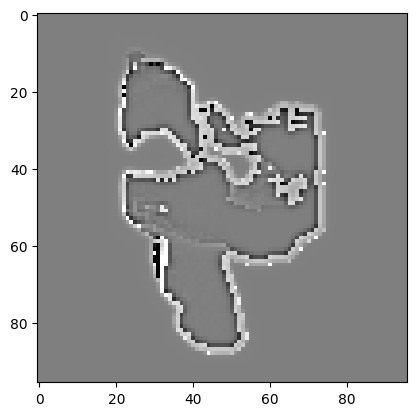

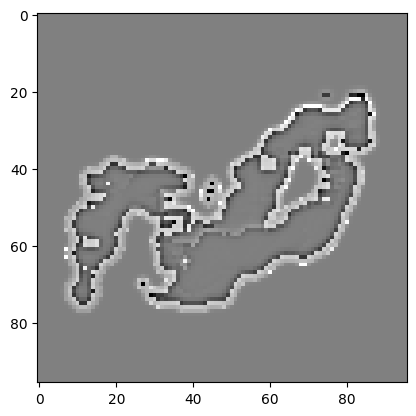

In [17]:
# Visualize sample
image, heatmap_gt = next(iter(val_dataloader))

plt.imshow(torch.squeeze(image[0], 0).numpy(), cmap='gray', vmin=-1, vmax=1)
plt.show()

plt.imshow(torch.squeeze(image[50], 0).numpy(), cmap='gray', vmin=-1, vmax=1)
plt.show()

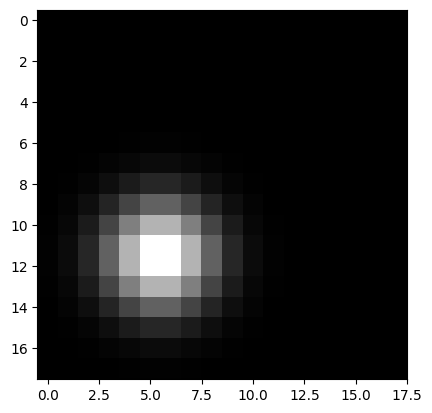

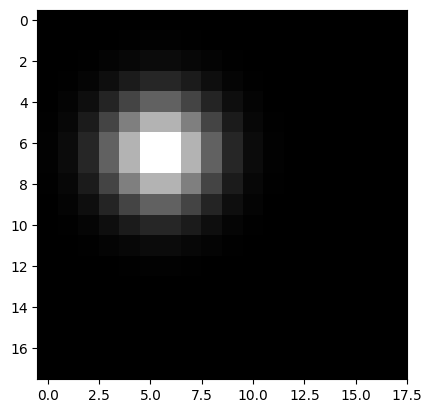

In [18]:
im_max = np.max(heatmap_gt[0][2].cpu().numpy())
plt.imshow(torch.squeeze(heatmap_gt[0][2], 0).numpy() / im_max, cmap='gray', vmin=0, vmax=1)
plt.show()

im_max = np.max(heatmap_gt[100][2].cpu().numpy())
plt.imshow(torch.squeeze(heatmap_gt[100][2], 0).numpy() / im_max, cmap='gray', vmin=0, vmax=1)
plt.show()

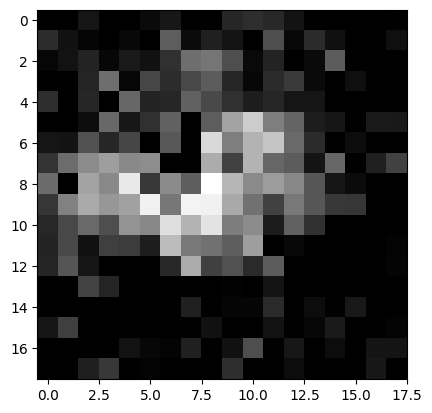

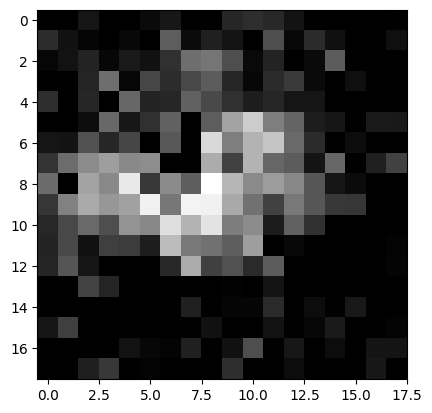

In [19]:
image = torch.unsqueeze(image.type(torch.FloatTensor).to(device), dim=1)
model.eval()
with torch.no_grad():
    pred = model(image)
    
    im_max = np.max(pred[0][2].cpu().numpy())
    plt.imshow(pred[0][2].cpu().numpy() / im_max, cmap='gray', vmin=0, vmax=1)
    plt.show()
    
    im_max = np.max(pred[100][2].cpu().numpy())
    plt.imshow(pred[100][2].cpu().numpy() / im_max, cmap='gray', vmin=0, vmax=1)
    plt.show()